# MALIGNANT COMMENTS CLASSIFICATION

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import string
import re

# packages from gensim
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess

# packages from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# packages from nltk
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train=pd.read_csv('MLtrain.csv')
df_train

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [4]:
df_train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df_test=pd.read_csv('MLtest.csv')
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [6]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
df_train.shape

(159571, 8)

In [8]:
df_test.shape

(153164, 2)

In [9]:
df_train.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

<AxesSubplot:>

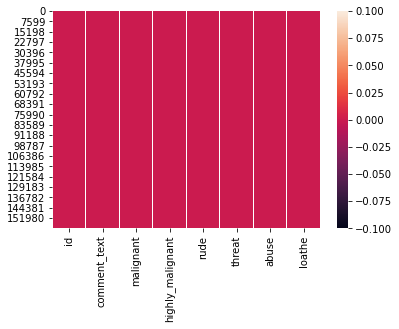

In [10]:
sns.heatmap(df_train.isnull())

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [13]:
df_train.columns

Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

In [14]:
df_train.drop(['id'],axis=1,inplace=True)

# EDA

In [15]:
cols=['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe',]
for col in cols:
    print(df_train[f'{col}'].value_counts())

0    144277
1     15294
Name: malignant, dtype: int64
0    157976
1      1595
Name: highly_malignant, dtype: int64
0    151122
1      8449
Name: rude, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: abuse, dtype: int64
0    158166
1      1405
Name: loathe, dtype: int64


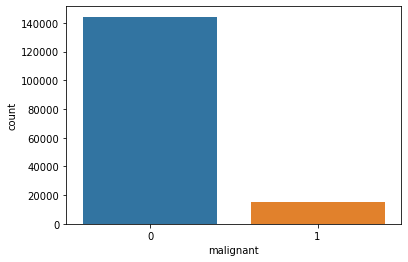

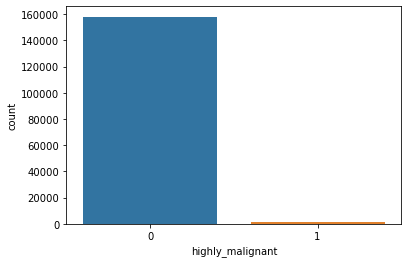

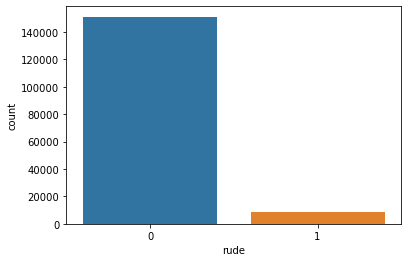

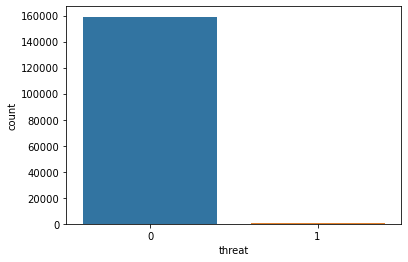

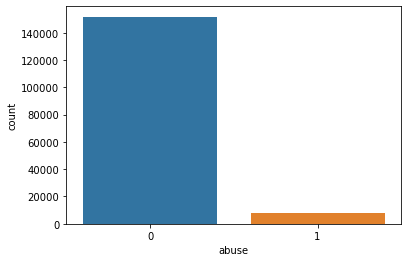

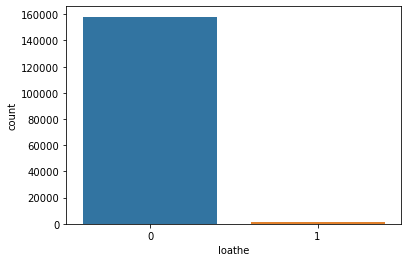

In [16]:
features = df_train.columns[1:]
for i in features:
    sns.countplot(df_train[i])
    plt.show()

Most of the comments are non-negative but still there are some highly malignant, rude and abuse comments.

In [17]:
counts=df_train.iloc[:,1:].sum()
counts

malignant           15294
highly_malignant     1595
rude                 8449
threat                478
abuse                7877
loathe               1405
dtype: int64

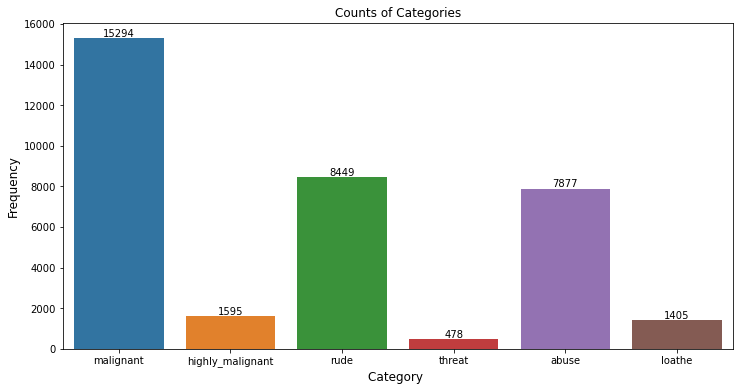

In [18]:

plt.figure(figsize=(12,6))
ax = sns.barplot(counts.index, counts.values)
plt.title("Counts of Categories")
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Category ', fontsize=12)
rects = ax.patches
labels = counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

<AxesSubplot:xlabel='comment_text', ylabel='Density'>

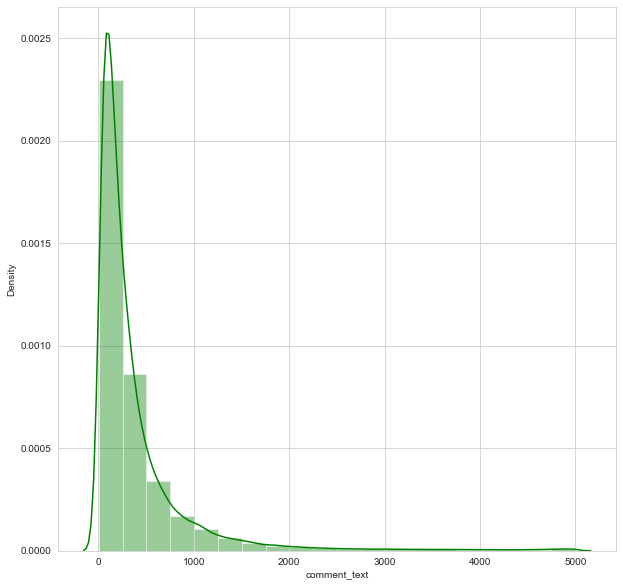

In [19]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
comment_len = df_train.comment_text.str.len()
sns.distplot(comment_len, bins=20, color = 'green')

In [20]:
df_train.corr().style.background_gradient(cmap='Oranges')

,malignant,highly_malignant,rude,threat,abuse,loathe
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


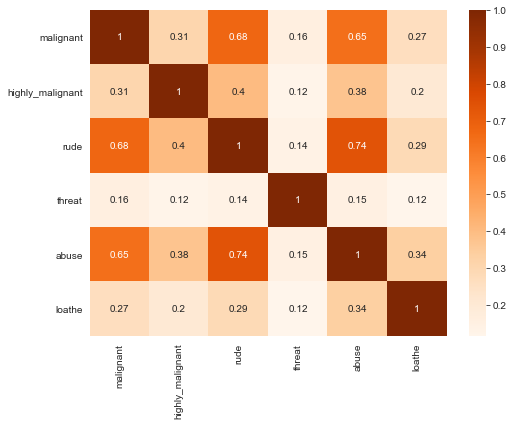

In [21]:
plt.figure(figsize=(8,6))
sns.heatmap(df_train.corr(), annot = True, cmap= "Oranges")
plt.show()


No negative correlation in the dataset.

Rude and malignant are correlated.

Likewise, Abuse and rude are correlated each other.

In [22]:
df_train['label'] = df_train[features].max(axis=1)
df_train.head(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0,0


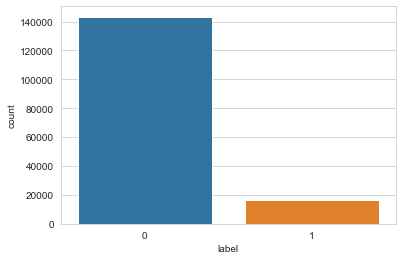

0    143346
1     16225
Name: label, dtype: int64

In [23]:
plt.figure(figsize = (6,4))
sns.countplot(df_train['label'])
plt.show()

df_train['label'].value_counts()

# Pre-Processing

In [24]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [25]:
import nltk, json, operator
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer 

In [26]:
#Defining the stop words
stop_words = stopwords.words('english')

#Defining the lemmatizer
lemmatizer = WordNetLemmatizer()

In [27]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
#Replacing '\n' in comment_text
df_train['comment_text'] = df_train['comment_text'].replace('\n',' ')

#Function Definition for using regex operations and other text preprocessing for getting cleaned texts
def clean_comments(text):
    
    #convert to lower case
    lowered_text = text.lower()
    
    #Replacing email addresses with 'emailaddress'
    text = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress', lowered_text)
    
    #Replace URLs with 'webaddress'
    text = re.sub(r'http\S+', 'webaddress', text)
    
    #Removing numbers
    text = re.sub(r'[0-9]', " ", text)
    
    #Removing the HTML tags
    text = re.sub(r"<.*?>", " ", text)
    
    #Removing Punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\_',' ',text)
    
    #Removing all the non-ascii characters 
    clean_words = re.sub(r'[^\x00-\x7f]',r'', text)
    
    #Removing the unwanted white spaces
    text = " ".join(text.split()) 
    
    #Splitting data into words
    tokenized_text = word_tokenize(text)
    
    #Removing remaining tokens that are not alphabetic, Removing stop words and Lemmatizing the text
    removed_stop_text = [lemmatizer.lemmatize(word) for word in tokenized_text if word not in stop_words if word.isalpha()]
   
    return " ".join(removed_stop_text)

In [29]:
df_train['comment_text'] = df_train['comment_text'].apply(clean_comments)

In [30]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
df_train.head(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label
0,explanation edits made username hardcore metal...,0,0,0,0,0,0,0
1,aww match background colour seemingly stuck th...,0,0,0,0,0,0,0
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0
3,make real suggestion improvement wondered sect...,0,0,0,0,0,0,0
4,sir hero chance remember page,0,0,0,0,0,0,0
5,congratulation well use tool well talk,0,0,0,0,0,0,0
6,cocksucker piss around work,1,1,1,0,1,0,1
7,vandalism matt shirvington article reverted pl...,0,0,0,0,0,0,0
8,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0,0
9,alignment subject contrary dulithgow,0,0,0,0,0,0,0


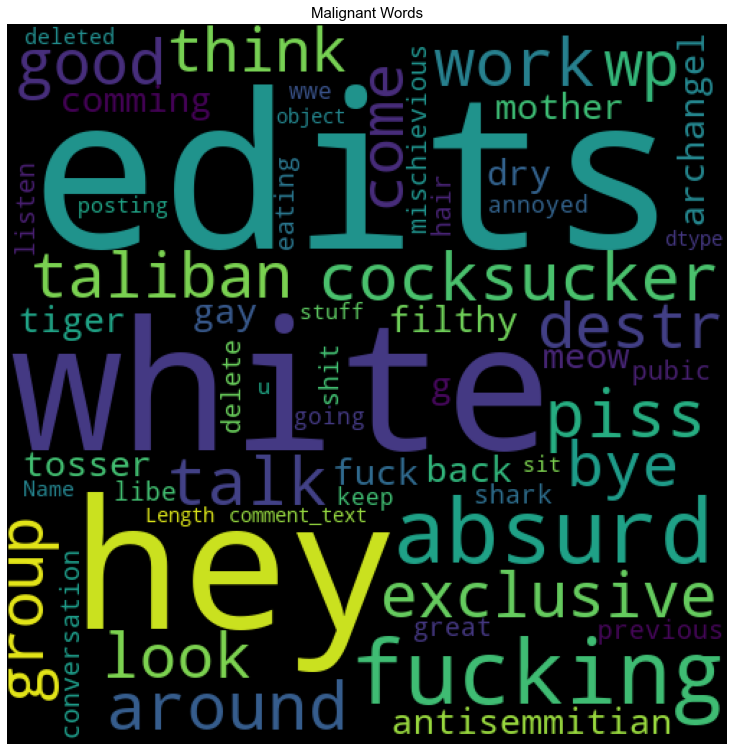

In [33]:
df_train_malignant=df_train[(df_train['malignant']==1)]

#Plotting for malignant
wordcloud=WordCloud(height=500,width=500,max_words=500).generate(str(df_train_malignant['comment_text']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='Malignant Words',fontdict={'fontsize':15, 'fontweight':10, 'color':'Black'})
plt.show()

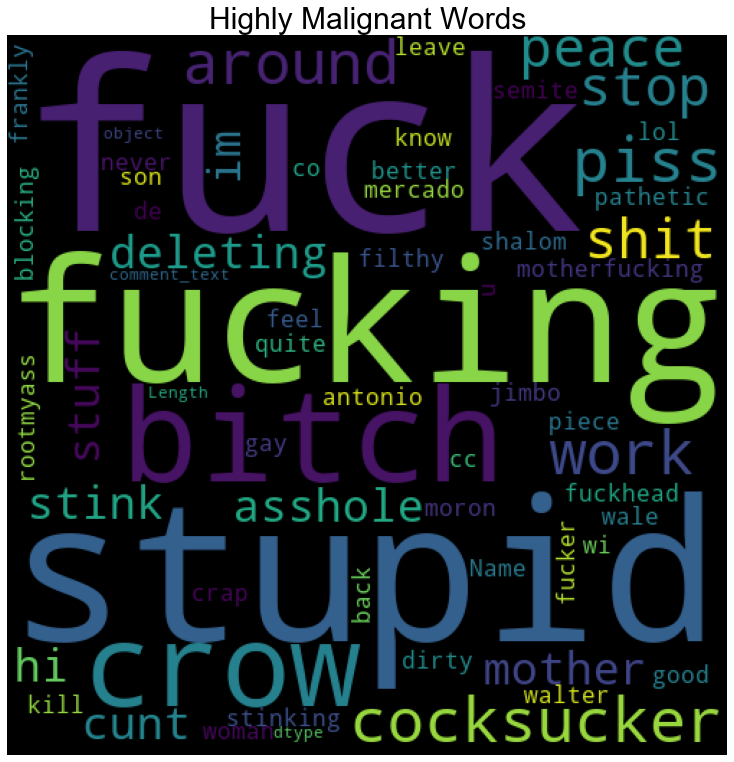

In [34]:
df_train_highlymalignant=df_train[(df_train['highly_malignant']==1)]

#Plotting for malignant
wordcloud=WordCloud(height=500,width=500,max_words=500).generate(str(df_train_highlymalignant['comment_text']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='Highly Malignant Words',fontdict={'fontsize':30, 'fontweight':30, 'color':'Black'})
plt.show()

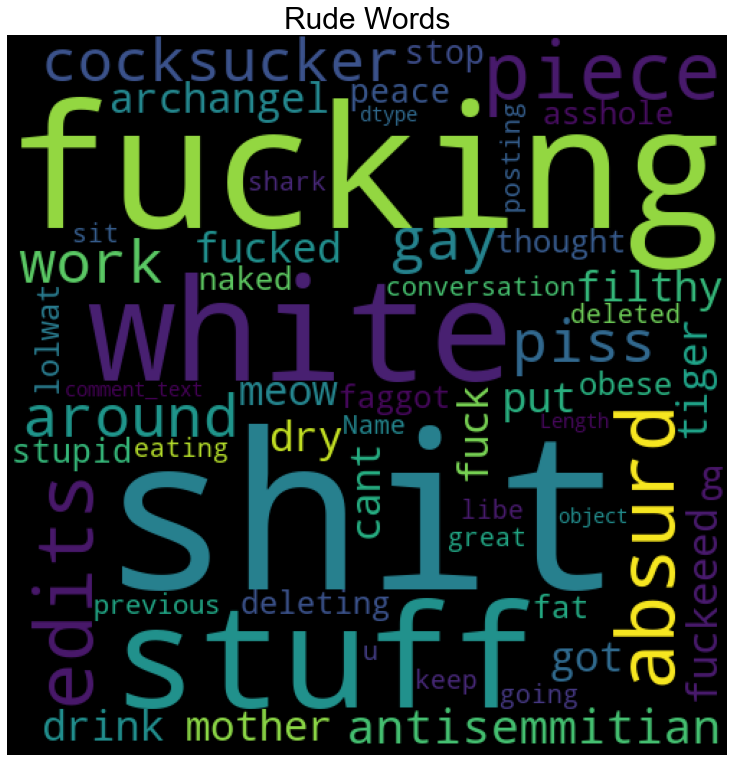

In [35]:
df_train_rude=df_train[(df_train['rude']==1)]

#Plotting for malignant
wordcloud=WordCloud(height=500,width=500,max_words=500).generate(str(df_train_rude['comment_text']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='Rude Words',fontdict={'fontsize':30, 'fontweight':30, 'color':'Black'})
plt.show()

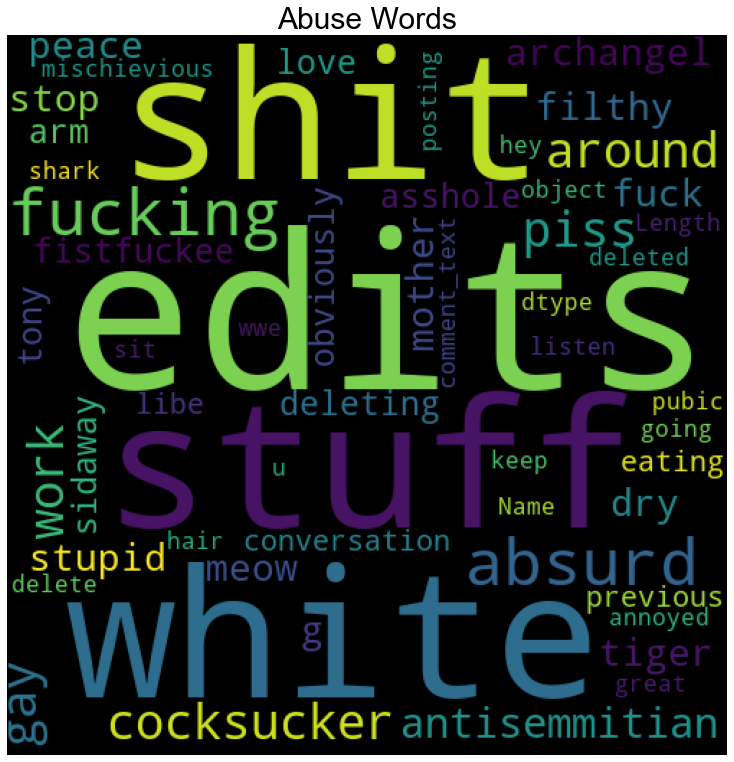

In [36]:
df_train_abuse=df_train[(df_train['abuse']==1)]

#Plotting for malignant
wordcloud=WordCloud(height=500,width=500,max_words=500).generate(str(df_train_abuse['comment_text']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='Abuse Words',fontdict={'fontsize':30, 'fontweight':30, 'color':'Black'})
plt.show()


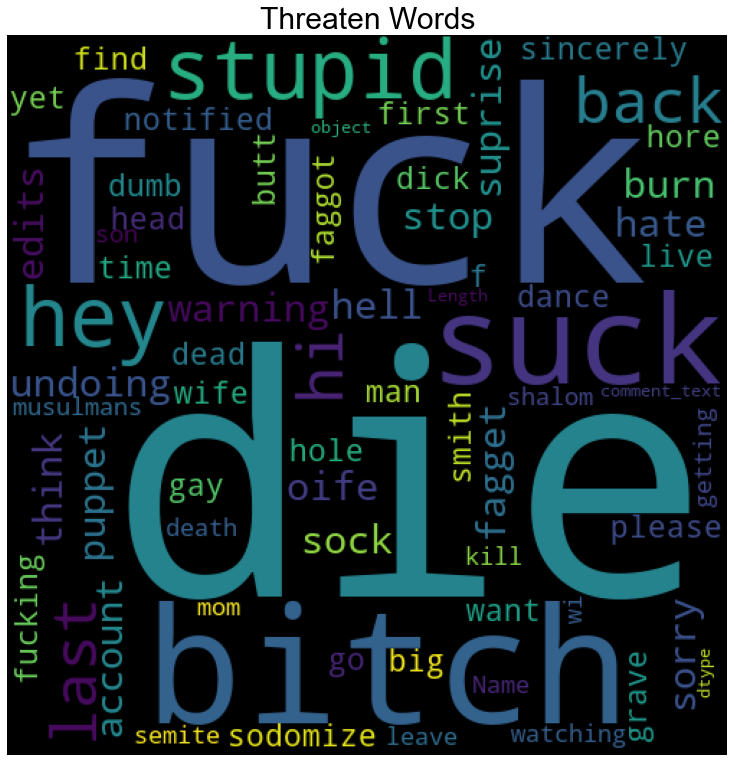

In [37]:
df_train_threat=df_train[(df_train['threat']==1)]

#Plotting for malignant
wordcloud=WordCloud(height=500,width=500,max_words=500).generate(str(df_train_threat['comment_text']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='Threaten Words',fontdict={'fontsize':30, 'fontweight':30, 'color':'Black'})
plt.show()

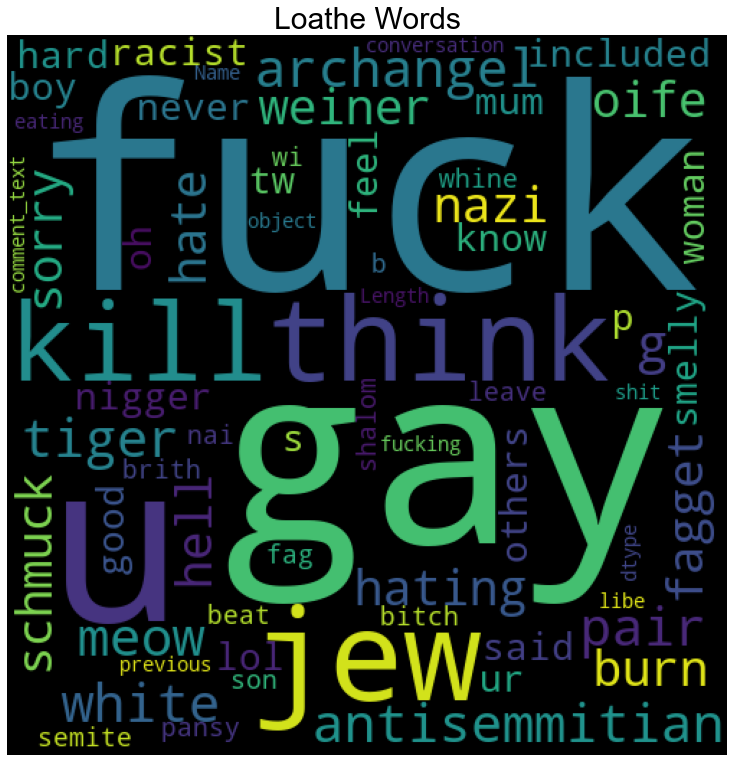

In [38]:
df_train_loathe=df_train[(df_train['loathe']==1)]

#Plotting for malignant
wordcloud=WordCloud(height=500,width=500,max_words=500).generate(str(df_train_loathe['comment_text']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='Loathe Words',fontdict={'fontsize':30, 'fontweight':30, 'color':'Black'})
plt.show()

In [39]:
tf_vec = TfidfVectorizer(max_features = 10000, stop_words='english')

In [40]:
X = tf_vec.fit_transform(df_train['comment_text'])

<AxesSubplot:xlabel='label', ylabel='count'>

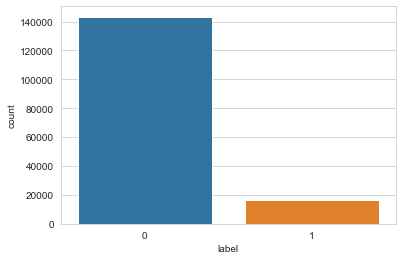

In [41]:
y = df_train['label']
sns.countplot(y)


<AxesSubplot:xlabel='label', ylabel='count'>

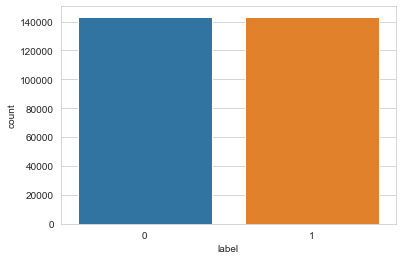

In [42]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

sm = SMOTE()
x_over,y_over = sm.fit_resample(X,y)
sns.countplot(y_over)

# Model Building

In [43]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import f1_score,accuracy_score,classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x_over,y_over,test_size = 0.25, random_state = 555)

In [45]:
lor = LogisticRegression()
lor.fit(x_train,y_train)
y_pred = lor.predict(x_test)
scr_lor = cross_val_score(lor,x_over,y_over,cv=5)


print("F1 score \n", f1_score(y_test,y_pred))
print("CV Score :", scr_lor.mean())
print("-------------------------------------------------------\n")
print("Classification Report \n", classification_report(y_test,y_pred))
print("--------------------------------------------------------\n")
print("Confusion Matrix \n", confusion_matrix(y_test,y_pred))
print("ROC AUC Score \n", roc_auc_score(y_test,y_pred))

F1 score 
 0.9316804181547008
CV Score : 0.931511914993558
-------------------------------------------------------

Classification Report 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     35600
           1       0.92      0.94      0.93     36073

    accuracy                           0.93     71673
   macro avg       0.93      0.93      0.93     71673
weighted avg       0.93      0.93      0.93     71673

--------------------------------------------------------

Confusion Matrix 
 [[32635  2965]
 [ 2028 34045]]
ROC AUC Score 
 0.9302470750634558


In [46]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred = dt.predict(x_test)  
scr_dt = cross_val_score(dt,x_over,y_over,cv=5)


print("F1 score \n", f1_score(y_test,y_pred))
print("CV Score :", scr_dt.mean())
print("-------------------------------------------------------\n")
print("Classification Report \n", classification_report(y_test,y_pred))
print("--------------------------------------------------------\n")
print("Confusion Matrix \n", confusion_matrix(y_test,y_pred))
print("ROC AUC Score \n", roc_auc_score(y_test,y_pred))

F1 score 
 0.947838518619375
CV Score : 0.9487359601629682
-------------------------------------------------------

Classification Report 
               precision    recall  f1-score   support

           0       0.96      0.93      0.95     35600
           1       0.93      0.96      0.95     36073

    accuracy                           0.95     71673
   macro avg       0.95      0.95      0.95     71673
weighted avg       0.95      0.95      0.95     71673

--------------------------------------------------------

Confusion Matrix 
 [[33035  2565]
 [ 1266 34807]]
ROC AUC Score 
 0.9464269687060912


In [47]:
mnb= MultinomialNB()
mnb.fit(x_train,y_train)
y_pred = mnb.predict(x_test)
scr_mnb = cross_val_score(mnb,x_over,y_over,cv=5)


print("F1 score \n", f1_score(y_test,y_pred))
print("CV Score :", scr_mnb.mean())
print("-------------------------------------------------------\n")
print("Classification Report \n", classification_report(y_test,y_pred))
print("--------------------------------------------------------\n")
print("Confusion Matrix \n", confusion_matrix(y_test,y_pred))
print("ROC AUC Score \n", roc_auc_score(y_test,y_pred))

F1 score 
 0.8944498811687405
CV Score : 0.8975625387751274
-------------------------------------------------------

Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.90      0.89     35600
           1       0.90      0.89      0.89     36073

    accuracy                           0.89     71673
   macro avg       0.89      0.89      0.89     71673
weighted avg       0.89      0.89      0.89     71673

--------------------------------------------------------

Confusion Matrix 
 [[32133  3467]
 [ 4083 31990]]
ROC AUC Score 
 0.8947126056339563


In [48]:
gb = GradientBoostingClassifier()
gb.fit(x_train,y_train)
y_pred = gb.predict(x_test)
scr_gb = cross_val_score(gb,x_over,y_over,cv=5)

print("F1 score \n", f1_score(y_test,y_pred))
print("CV Score :", scr_gb.mean())
print("-------------------------------------------------------\n")
print("Classification Report \n", classification_report(y_test,y_pred))
print("--------------------------------------------------------\n")
print("Confusion Matrix \n", confusion_matrix(y_test,y_pred))
print("ROC AUC Score \n", roc_auc_score(y_test,y_pred))

F1 score 
 0.8085208540059536
CV Score : 0.8346832479741477
-------------------------------------------------------

Classification Report 
               precision    recall  f1-score   support

           0       0.76      0.97      0.85     35600
           1       0.96      0.70      0.81     36073

    accuracy                           0.83     71673
   macro avg       0.86      0.83      0.83     71673
weighted avg       0.86      0.83      0.83     71673

--------------------------------------------------------

Confusion Matrix 
 [[34450  1150]
 [10814 25259]]
ROC AUC Score 
 0.8339578147869317


In [49]:
pac = PassiveAggressiveClassifier()
pac.fit(x_train,y_train)
y_pred = pac.predict(x_test)
scr_pac = cross_val_score(pac,x_over,y_over,cv=5)


print("F1 score \n", f1_score(y_test,y_pred))
print("CV Score :", scr_pac.mean())
print("-------------------------------------------------------\n")
print("Classification Report \n", classification_report(y_test,y_pred))
print("--------------------------------------------------------\n")
print("Confusion Matrix \n", confusion_matrix(y_test,y_pred))
print("ROC AUC Score \n", roc_auc_score(y_test,y_pred))

F1 score 
 0.9374053981648919
CV Score : 0.9371241915689221
-------------------------------------------------------

Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     35600
           1       0.91      0.97      0.94     36073

    accuracy                           0.93     71673
   macro avg       0.94      0.93      0.93     71673
weighted avg       0.94      0.93      0.93     71673

--------------------------------------------------------

Confusion Matrix 
 [[32009  3591]
 [ 1082 34991]]
ROC AUC Score 
 0.9345672402902105


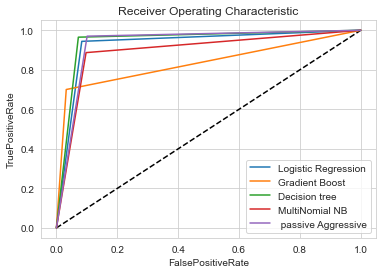

In [50]:
# roc auc curve for all the models

y_pred_prob1 = lor.predict(x_test)
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

y_pred_prob2 = gb.predict(x_test)
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)

y_pred_prob3 = dt.predict(x_test)
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)

y_pred_prob4 = mnb.predict(x_test)
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4)

y_pred_prob5 = pac.predict(x_test)
fpr5 , tpr5, thresholds5 = roc_curve(y_test, y_pred_prob5)



plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Logistic Regression")
plt.plot(fpr2, tpr2, label= "Gradient Boost")
plt.plot(fpr3, tpr3, label= "Decision tree")
plt.plot(fpr4, tpr4, label= "MultiNomial NB")
plt.plot(fpr5, tpr5, label = " passive Aggressive")
plt.legend()
plt.xlabel("FalsePositiveRate")
plt.ylabel("TruePositiveRate")
plt.title('Receiver Operating Characteristic')
plt.show()

# Hyperparameter Tuning

In [51]:
#Lets try to improve the accuracy of model by hyper parameter tuning,

param = {'C': [1.0,1.2,1.4,1.6,1.8],
        'fit_intercept':[True], 'max_iter': [1000]}

# Applying randomized search CV to increase the accuracy,

rg = RandomizedSearchCV(pac, param_distributions = param, cv= 5)
rg.fit(x_train,y_train)
rg.best_params_

{'max_iter': 1000, 'fit_intercept': True, 'C': 1.0}

In [52]:
#final model accuracy,

model = PassiveAggressiveClassifier(C = 1.0, max_iter = 1000, fit_intercept = True)
                               
model.fit(x_train,y_train)
y_pred = model.predict(x_test)


print("F1 score \n", f1_score(y_test,y_pred))
print("-------------------------------------------------------\n")
print("Classification Report \n", classification_report(y_test,y_pred))
print("--------------------------------------------------------\n")
print("Confusion Matrix \n", confusion_matrix(y_test,y_pred))
print("ROC AUC Score \n", roc_auc_score(y_test,y_pred))

F1 score 
 0.9379491932992114
-------------------------------------------------------

Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     35600
           1       0.91      0.97      0.94     36073

    accuracy                           0.94     71673
   macro avg       0.94      0.94      0.94     71673
weighted avg       0.94      0.94      0.94     71673

--------------------------------------------------------

Confusion Matrix 
 [[32144  3456]
 [ 1163 34910]]
ROC AUC Score 
 0.9353405843394341


(2.5, -0.5)

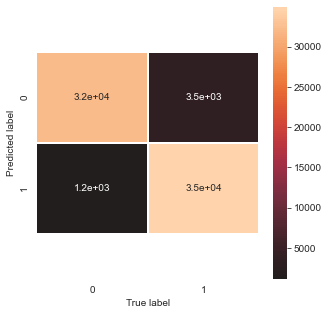

In [53]:
# Confusion matrix Visualization
fig, ax =plt.subplots(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,linewidths=1,center=0)
plt.xlabel("True label")
plt.ylabel("Predicted label")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

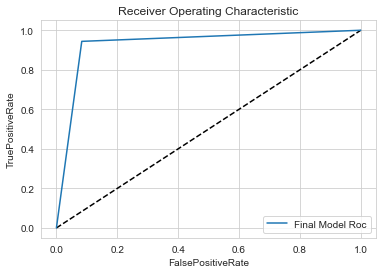

In [54]:
#Roc Curve for final model,

y_pred_fin = model.predict(x_test)
fpr , tpr, thresholds = roc_curve(y_test, y_pred_fin)


plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Final Model Roc")
plt.legend()
plt.xlabel("FalsePositiveRate")
plt.ylabel("TruePositiveRate")
plt.title('Receiver Operating Characteristic')
plt.show()

In [55]:
import joblib
joblib.dump(model,"Malignant_Comment_Predict.pkl")

['Malignant_Comment_Predict.pkl']

# Prediction

In [56]:
#aplying to test data,

df_test['comment_text'] = df_test['comment_text'].apply(clean_comments)
test = tf_vec.fit_transform(df_test['comment_text'])

In [57]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,rfc title fine imo
2,00013b17ad220c46,source zawe ashton lapland
3,00017563c3f7919a,look back source information updated correct f...
4,00017695ad8997eb,anonymously edit article


In [58]:
#Loading the test data

mod = joblib.load("Malignant_Comment_Predict.pkl")
prediction = mod.predict(test)
prediction = pd.DataFrame(prediction)

In [59]:
# To get the data in CSV format,

prediction.to_csv("Malignant_Classifier_Comments_Prediction.csv", index = 'False')